In [14]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

# make user code available:
import sys
import os
module_path = os.path.abspath('../code')
if module_path not in sys.path:
    sys.path.insert(0, os.path.abspath('../code'))

from dataset import split_dataset, BoneAgeDataset, normalize_target
from transforms import get_transform
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset
-------

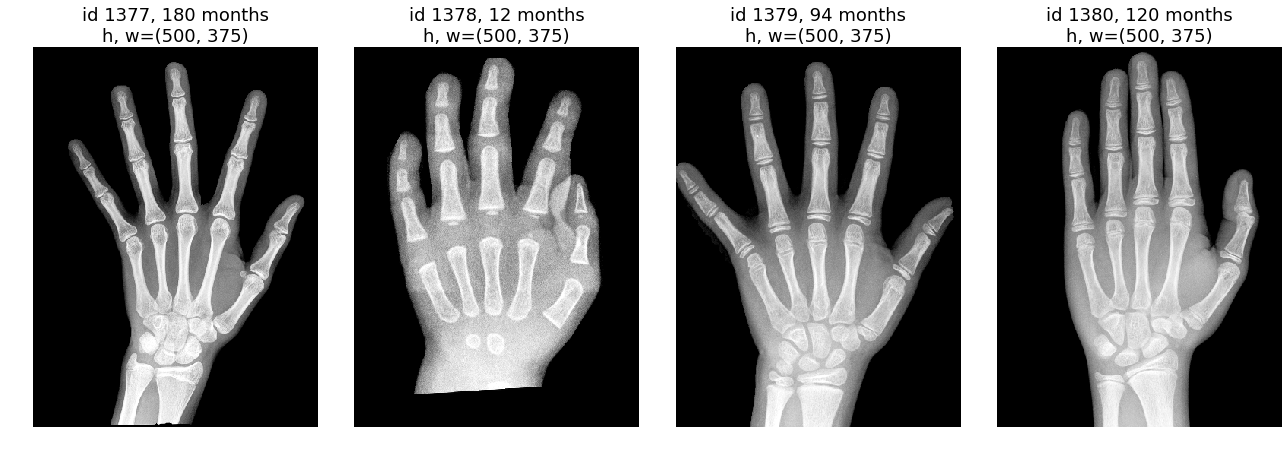

In [15]:
crop_dict = {'center': (1040, 800), 'crop_size': (2000, 1500)}
scale = 0.25
train_transform = get_transform(augmentation=False, crop_dict=crop_dict, scale=scale)

bone_age_frame = pd.read_csv('f:/Sandbox/hand/data/train.csv')
root_dir = 'f:/Sandbox/hand/data/fitted_train'
train_df, _ = split_dataset(bone_age_frame, 5, 5, root_dir, gender='a')
boneage_dataset = BoneAgeDataset(bone_age_frame=train_df, root_dir=root_dir, transform=train_transform)

nimages = 4
fig = plt.figure(figsize=(18, 8))
for i, sample in enumerate(islice(boneage_dataset, nimages), 1):
    image, label, img_id = sample['image'], sample['label'], sample['id']
    if torch.is_tensor(image):
        image = np.squeeze(image.numpy())
        label = normalize_target(label.item(), reverse_norm=True)

    ax = plt.subplot(1, nimages, i)
    plt.tight_layout()
    ax.set_title(f'id {img_id}, {label:n} months\nh, w={image.shape}', fontsize=18)
    ax.axis('off')
    ax.imshow(image, cmap='Greys_r')
plt.tight_layout()
plt.pause(0.001)  # pause a bit so that plots are updated
plt.show()